In [7]:
import json
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

def read_json(json_file):
    with open(json_file) as js:
        json_data = json.load(js)
    return json_data

In [8]:
best = 'sample_dataset_1/bestshots.json'
#best2 = '22-03007/bestshots.json'
item = 'sample_dataset_1/itemsets.json'
#item2 = '22-03007/items.json'
category = 'sample_dataset_2/category_infos.json'
#category2 = '22-03007/categories.json'
products = 'sample_dataset_2/products_meta.json'
#products2 = '22-03007/products.json'

In [13]:
def EDA_word2vec(best, item, category, products):
    
    bestshots_json = read_json(best)
    itemsets_json = read_json(item)
    category_json = read_json(category)
    products_json = read_json(products)

    category_4 = category_json['421B6D0E746C4E6D']
    category_b = category_json['B57D4F97C0E44A11']

    best_df = pd.read_json(best)
    item_df = pd.read_json(item)
    
    prod_tags = pd.DataFrame(products_json).T.reset_index(drop=True)[['_id', 'tags', 'name', 'images']]
    
    category_en4 = pd.DataFrame(category_4)
    category_enb = pd.DataFrame(category_b)
    
    item_df.rename(columns={'_id' : 'id', 'enterpriseId' : 'enterprise_id'}, inplace=True)
    best_item = pd.merge(best_df, item_df, on=['id', 'enterprise_id', 'projectId'])

    df_b, df_4 = best_item['enterprise_id'].unique().tolist()
    
    def get_productId(items_list):
        new_list = []
        for item in items_list:
            new_list.append(item['productId'])
        return new_list

    best_item['product_id'] = best_item['items'].apply(get_productId)
    best_item.drop(columns=['items'], inplace=True)
    
    def prod_name(categories):
        x = categories.copy()
        w = []
        for i in x:
            for z in prod_tags['_id']:
                if z in i:
                    b = prod_tags.iloc[np.where(prod_tags['_id'] == z)]
                    w.append(b['name'].iloc[0])
        return w
    
    best_item['name'] = best_item['product_id'].apply(prod_name)
    
    best_item = best_item[['enterprise_id', 'awesome_score', 'product_id', 'name', 'top_style', 'projectId']]
 
    best_item_4 = best_item[best_item['enterprise_id'] == df_4]
    best_item_b = best_item[best_item['enterprise_id'] == df_b]
    
    def flatten_data(best_item):
    
        best_items = best_item.join(best_item['product_id'].apply(lambda x: pd.Series(x)).stack().reset_index(1, name='items').drop('level_1', axis=1))
        best_items.drop(columns=['product_id', 'name'],inplace=True)

        return best_items

    def flatten_data2(names, best_items):
        x = names['name'].apply(lambda x: pd.Series(x)).stack().reset_index(1, name='names').drop('level_1', axis=1)
        df = pd.concat([best_items, x], axis=1)
        return df
    
    flatten_data = flatten_data(best_item)
    
    flatten = flatten_data2(best_item,flatten_data)
    
    prod_df = pd.merge(flatten, prod_tags, left_on='items', right_on='_id').drop(['_id'], axis=1)
    prod_df = pd.merge(prod_df, prod_df['items'].value_counts().reset_index(),
                       left_on='items', right_on = 'index').rename(columns = {'items': 'product_id','items_y':'use_count'}).drop(['index'], axis=1)
    prod_df.drop(columns=['name', 'use_count'], inplace=True)
    best_item_4 = best_item[best_item['enterprise_id'] == df_4]
    best_item_b = best_item[best_item['enterprise_id'] == df_b]
    
    
    return  best_item_4, best_item_b, prod_df

In [14]:
def EDA_cf(best, item, category, products):
    
    bestshots_json = read_json(best)
    itemsets_json = read_json(item)
    category_json = read_json(category)
    products_json = read_json(products)

    category_4 = category_json['421B6D0E746C4E6D']
    category_b = category_json['B57D4F97C0E44A11']

    best_df = pd.read_json(best)
    item_df = pd.read_json(item)

    category_en4 = pd.DataFrame(category_4)
    category_enb = pd.DataFrame(category_b)

    item_df.rename(columns={'_id' : 'id', 'enterpriseId' : 'enterprise_id'}, inplace=True)
    best_item = pd.merge(best_df, item_df, on=['id', 'enterprise_id', 'projectId'])

    df_b, df_4 = best_item['enterprise_id'].unique().tolist()
    
    def get_productId(items_list):
        new_list = []
        for item in items_list:
            new_list.append(item['productId'])
        return new_list

    best_item['items'] = best_item['items'].apply(get_productId)
    
    best_item['top3_style'] = best_item['style_predictions'].apply(lambda x: sorted([(name, score) for name, score in x.items()], key=lambda x: x[1], reverse=True)[:3])
    # top 3 style 점수, 이름 가져오기
    best_item['top3_style'] = best_item['top3_style'].apply(lambda x: [name for name, score, in x])
    # top3_style 이름만 가져오기
    best_item['top3_style'] = best_item['top3_style'].apply(lambda x: ' '.join(x))
    # 리스트 제거 
    
    items_stack = pd.DataFrame(best_item['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)
    
    products_df = pd.merge(best_item[['enterprise_id', 'top3_style', 'top_style', 'projectId', 'awesome_score']]
                       .reset_index(),
                       items_stack.reset_index(),
                       on='index').drop(['index'],axis=1).rename(columns = {0:'product_id'})
    
    prod_tags = pd.DataFrame(products_json).T.reset_index(drop=True)[['_id', 'tags', 'name', 'images']]
    
    prod_df = pd.merge(products_df, prod_tags, left_on='product_id', right_on='_id').drop(['_id'], axis=1)
    prod_df = pd.merge(prod_df, prod_df['product_id'].value_counts().reset_index(),
                       left_on='product_id', right_on = 'index').rename(columns = {'product_id_x': 'product_id','product_id_y':'use_count'}).drop(['index'], axis=1)
    
    prod_4 = prod_df[prod_df['enterprise_id'] == df_4].reset_index(drop=True)
    prod_b = prod_df[prod_df['enterprise_id'] == df_b].reset_index(drop=True)

    return prod_4, prod_b

In [20]:
best_item_4, best_item_b, prod_df = EDA_word2vec(best, item, category, products)
prod_4, prod_b = EDA_cf(best, item, category, products)

### iteration step :  0 rmse :  0.9995642007087387
### iteration step :  10 rmse :  0.9949816305392217
### iteration step :  20 rmse :  0.9866737681951868
### iteration step :  30 rmse :  0.9678396340782486
### iteration step :  40 rmse :  0.9241828381952503
### iteration step :  50 rmse :  0.8355749763327519
### iteration step :  60 rmse :  0.6995219077331464
### iteration step :  70 rmse :  0.5421917257919174
### iteration step :  80 rmse :  0.3946926258430272
### iteration step :  90 rmse :  0.27632696886367286
### iteration step :  100 rmse :  0.19154566473305637
### iteration step :  110 rmse :  0.13577977270389094
### iteration step :  120 rmse :  0.10108844387620089
### iteration step :  130 rmse :  0.07970847074010538
### iteration step :  140 rmse :  0.06592523687514722
### iteration step :  150 rmse :  0.056337868996430486
### iteration step :  160 rmse :  0.04921460193443186
### iteration step :  170 rmse :  0.04372933967195364
### iteration step :  180 rmse :  0.03944761557

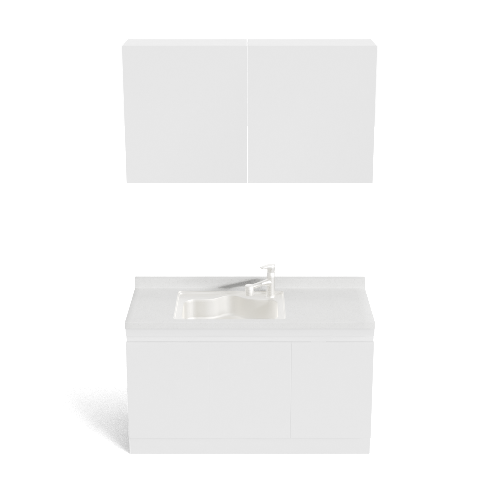

1순위 추천 아이템 : 싱크대 상+하부장 세트 (싱크대) (화이트)


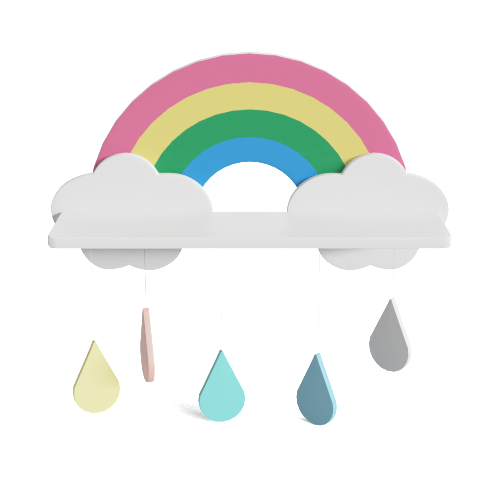

2순위 추천 아이템 : 무지개 우드 선반 (화이트)


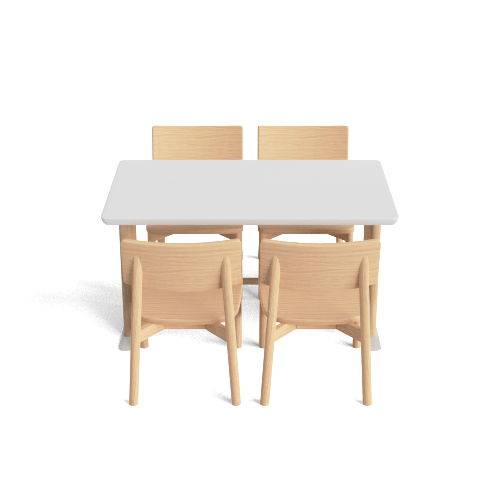

3순위 추천 아이템 : 포레 컴포트 4인 식탁세트 (원목의자4) (화이트)


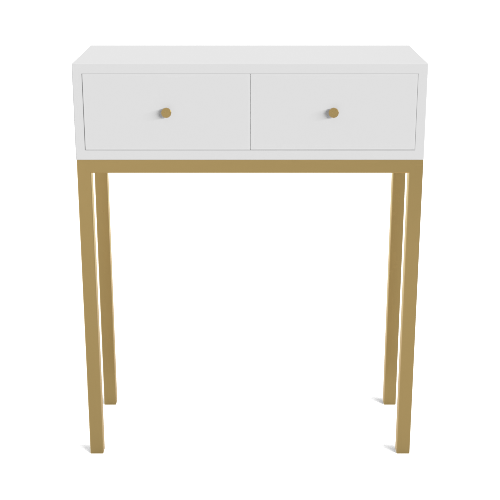

4순위 추천 아이템 : 벨르 골드 미니 콘솔 화이트 (화이트)


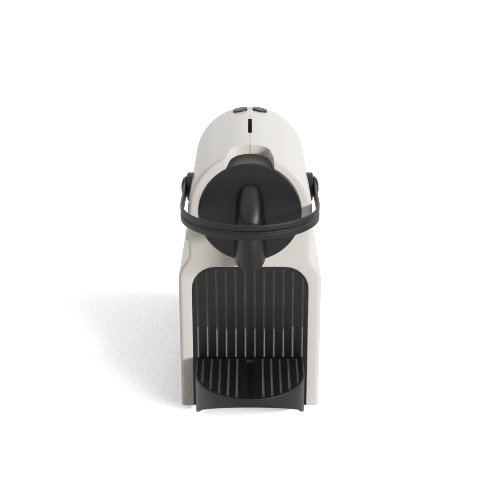

5순위 추천 아이템 : 크룹스 이니시아 커피머신 (화이트)


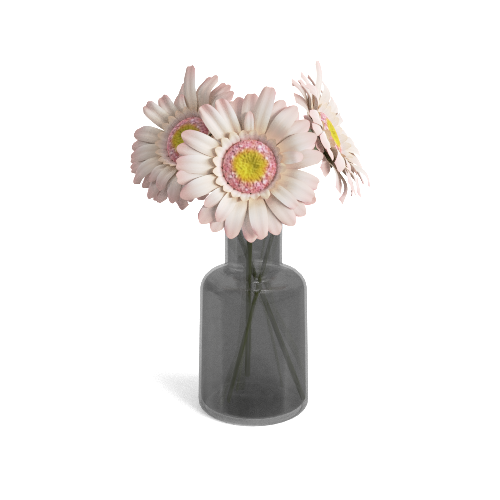

6순위 추천 아이템 : 거베라 조화_2color (피치핑크)


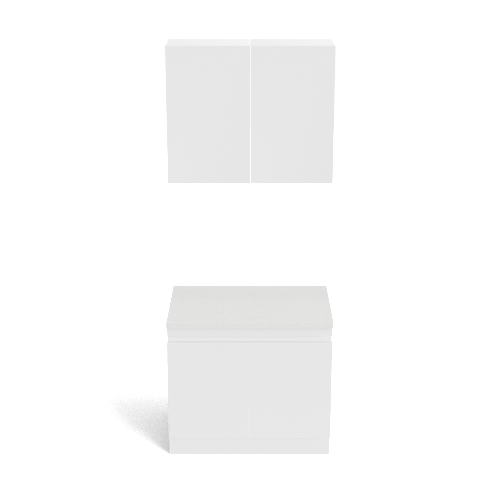

7순위 추천 아이템 : 싱크대 상+하부장 세트 (투도어) (화이트)


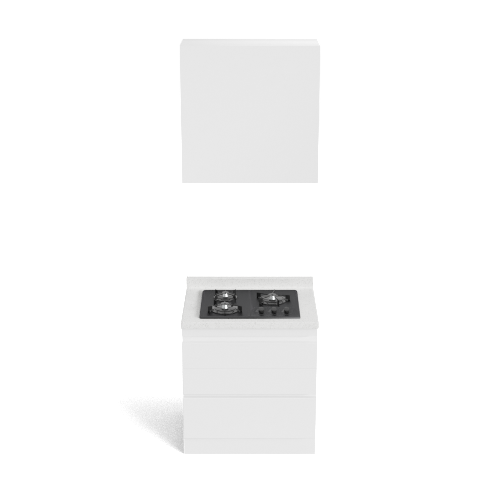

8순위 추천 아이템 : 싱크대 상+하부장 세트 (가스렌지) (화이트)


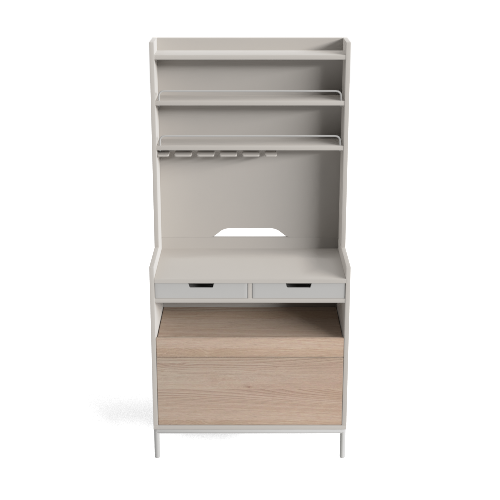

9순위 추천 아이템 : 구스토 800폭 높은 카페장/홈카페 다용도 주방 수납장(그레이+뉴트럴밤나무)


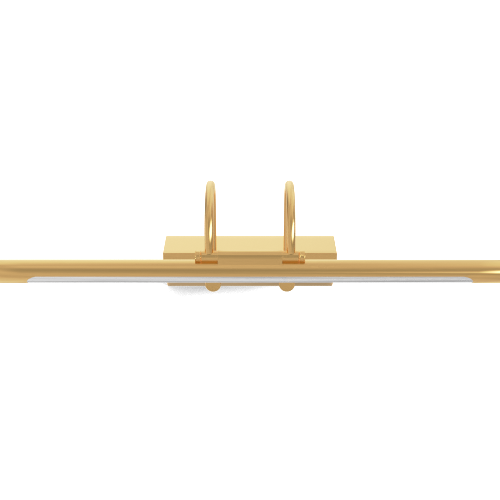

10순위 추천 아이템 : 갤러리 벽등 2colors (골드) (소)


In [64]:
# 1개만 선택할 시에 유사한 이미지 추천
# 2개 이상 -> 전문가 데이터를 활용해 유사도 및 cf-svd

def recommend_word(best_item, prod, item_name):
    
    if len(item_name) == 1:
        best_items = best_item[['projectId', 'product_id', 'name']]

        def build_model(best_item):
            sentence = best_item['name'].values.tolist()
            embedding_model = Word2Vec(sentence,
                                       vector_size=20,
                                       window=5,
                                       min_count=1,
                                       workers=4,
                                       epochs=200,
                                       sg=1)
            return embedding_model

        def get_rec_result(df, prod, model, search_word_list, topn = 10):
            result = model.wv.most_similar(positive=search_word_list, topn=topn)

            for search_word in search_word_list:
                print(f'사용자가 선택한 아이템 : {search_word}')
                search_images = prod[prod['name'] == search_word]['images'].values.tolist()[0]
                try:
                    res = requests.get(search_images[0])
                    img = Image.open(BytesIO(res.content))
                    display(img)
                except:
                    print('이미지 없음\n')

            print("="*80)
            print(f"추천 아이템 Top{topn}")
            print("="*80)

            # 추천된 이미지들 보여주기
            for i, (name, _) in enumerate(result):   
                    images = prod[prod['name'] == name]['images'].values.tolist()[0]
                    try:
                        res = requests.get(images[0])
                        img = Image.open(BytesIO(res.content))
                        display(img)
                    except:
                        print('이미지 없음\n')
                    print(f'{i+1}순위 추천 아이템 : {name}')
                    print("-"*60)

            return result

        emb_model_b = build_model(best_items)

        search_word_list = item_name

        return get_rec_result(best_items, prod, emb_model_b, search_word_list, topn=10)
    
    else:
        
        search_userId = 'user'
        matrix = prod.pivot_table('awesome_score', index='projectId', columns='name').fillna(0).round().astype(int)
        matrix.loc['user'] = 0
        for i in item_name:
            x = matrix.loc['user'].keys() == i
            x = x.astype(int)
            matrix.loc['user'] = x
        
        def get_rmse(R, P, Q, non_zeros):
            error = 0
            full_pred_matrix = np.dot(P, Q.T)

            x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
            y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
            R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
            full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
            mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
            rmse = np.sqrt(mse)

            return rmse
    
        def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):

            num_users, num_items = R.shape
            np.random.seed(33)
            P = np.random.normal(scale=1./K, size=(num_users, K))
            Q = np.random.normal(scale=1./K, size=(num_items, K))

            prev_rmse = 10000
            break_count = 0


            non_zeros = [(i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]


            for step in range(steps):
                for i, j, r in non_zeros:

                    eij = r - np.dot(P[i, :], Q[j, :].T)
                    P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
                    Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])

                rmse = get_rmse(R, P, Q, non_zeros)
                if (step % 10) == 0:
                    print("### iteration step : ", step, "rmse : ", rmse)

            return P, Q

        P, Q = matrix_factorization(matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda=0.01)
        pred_matrix = np.dot(P, Q.T)
        pred_matrix_df = pd.DataFrame(data=pred_matrix, index=matrix.index, columns=matrix.columns)

        def get_unseen_items(ratings_matrix, userId):

            user_rating = ratings_matrix.loc[userId, :]
            already_seen = user_rating[user_rating > 0].index.tolist()
            items_list = ratings_matrix.columns.tolist()

            unseen_list = [item for item in items_list if item not in already_seen]
            return unseen_list

        def recomm_item_by_userid(pred_df, userId, unseen_list, top_n=10):
            recomm_items = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
            return recomm_items

        unseen_list = get_unseen_items(matrix, search_userId)

        recomm_items = recomm_item_by_userid(pred_matrix_df, search_userId, unseen_list, top_n=10)

        recomm_items_df = pd.DataFrame(data=recomm_items.values, index=recomm_items.index, columns=['pred_score'])

        def show_rec_items(search_userId, rec_df):
            item_list = rec_df.index.tolist()
            for i, item in enumerate(item_list):
                images = prod[prod['name'] == item]['images'].values.tolist()[0]
                try:
                    res = requests.get(images[0])
                    img = Image.open(BytesIO(res.content))
                    display(img)
                except:
                    print('이미지 없음\n')
                print(f'{i+1}순위 추천 아이템 : {item}')
                
        return show_rec_items(search_userId, recomm_items_df)          

recommend_word(best_item_b, prod_b, ['화이트 정사각 LED 방등 화이트', '퓨어 30cm 슬림형 3D LED벽시계 (M) (화이트)'])

### iteration step :  0 rmse :  0.999553449476838
### iteration step :  10 rmse :  0.9949756077292499
### iteration step :  20 rmse :  0.9866331317519748
### iteration step :  30 rmse :  0.9676431171656529
### iteration step :  40 rmse :  0.9235872193653255
### iteration step :  50 rmse :  0.8345895693131461
### iteration step :  60 rmse :  0.6981768104485232
### iteration step :  70 rmse :  0.5396922375527382
### iteration step :  80 rmse :  0.3918230349153344
### iteration step :  90 rmse :  0.27411435948591495
### iteration step :  100 rmse :  0.18958687182774164
### iteration step :  110 rmse :  0.13308785974001142
### iteration step :  120 rmse :  0.09721055365361546
### iteration step :  130 rmse :  0.07486704142499155
### iteration step :  140 rmse :  0.060585429396643076
### iteration step :  150 rmse :  0.050901033371533407
### iteration step :  160 rmse :  0.04394711039266063
### iteration step :  170 rmse :  0.03878533529602855
### iteration step :  180 rmse :  0.03490235701

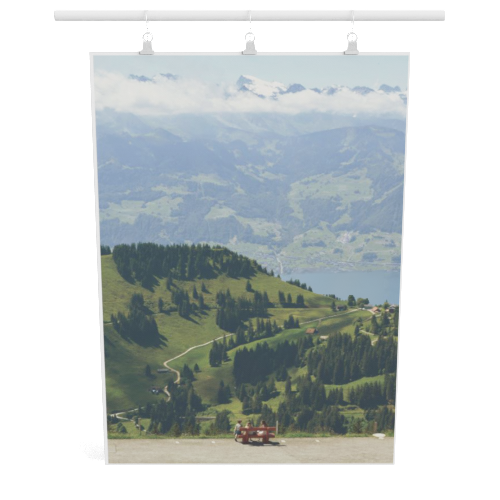

1순위 추천 아이템 : Fabric Poster - Switzerland #1 (50x70)


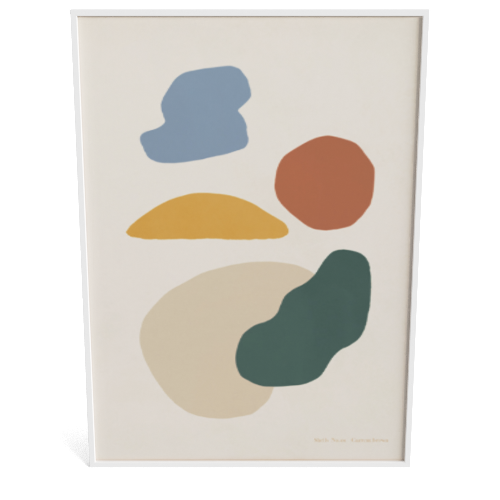

2순위 추천 아이템 : POSTER 1
이미지 없음

3순위 추천 아이템 : Archisketch Latte Cup


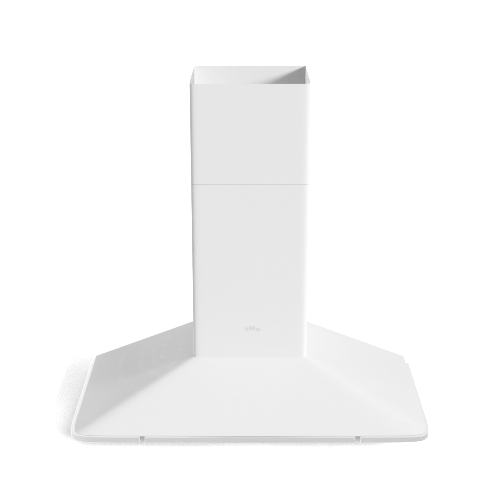

4순위 추천 아이템 : 침니형 화이트 후드 로빈 RNH-90(화이트)


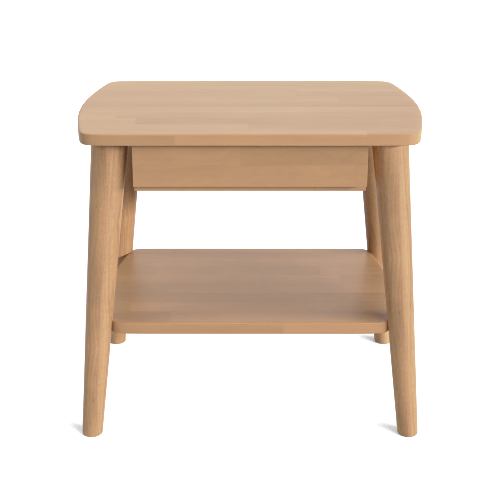

5순위 추천 아이템 : 헤디 고무나무 원목 협탁 2colors (내추럴)


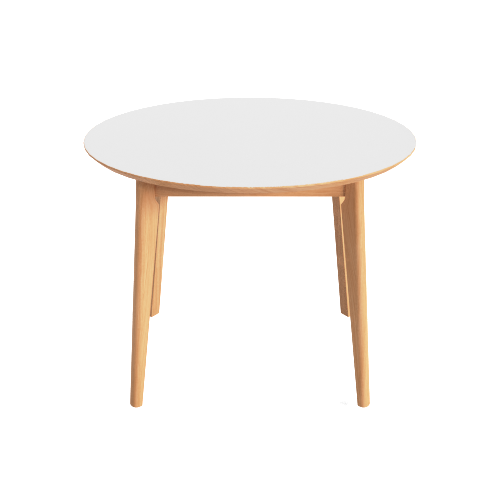

6순위 추천 아이템 : 오크원형테이블(1000) (화이트오크)


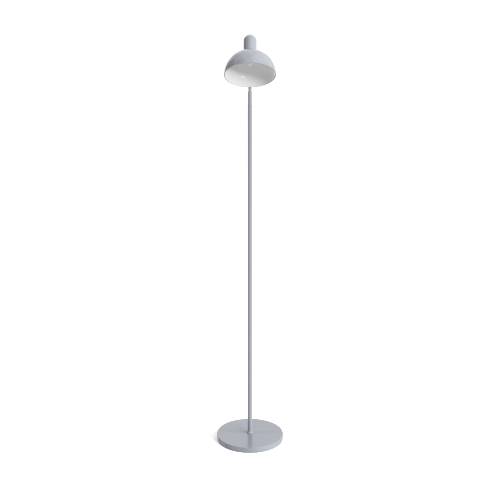

7순위 추천 아이템 : 데일리라잇 장스탠드 7colors (그레이)


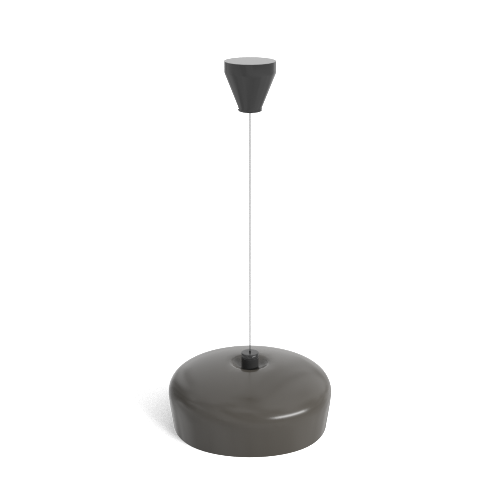

8순위 추천 아이템 : 러블430 펜던트 (블랙)


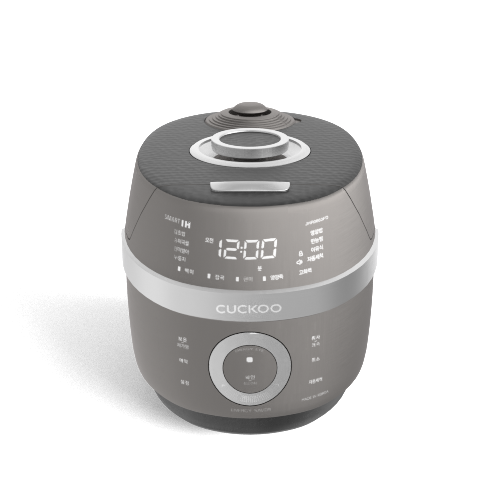

9순위 추천 아이템 : 6인용 IH압력밥솥 CRP-JHR0660FD (그레이)


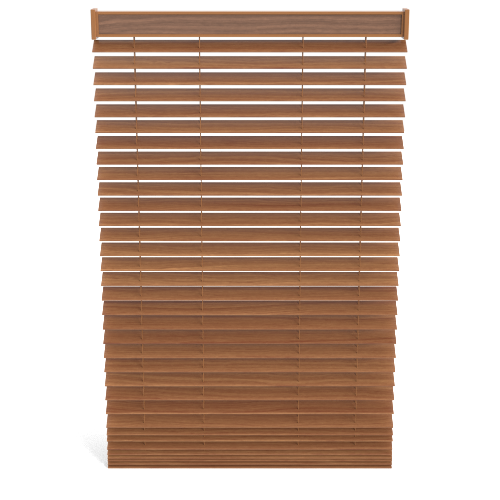

10순위 추천 아이템 : PREMIUM 맞춤 우드 블라인드 브라운


In [35]:
def recommend_cf(prod, search_userId):
    matrix = prod.pivot_table('awesome_score', index='projectId', columns='name').fillna(0).round().astype(int)
    def get_rmse(R, P, Q, non_zeros):
        error = 0
        full_pred_matrix = np.dot(P, Q.T)

        x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
        y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
        R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
        full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
        mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
        rmse = np.sqrt(mse)

        return rmse
    
    def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda=0.01):
 
        num_users, num_items = R.shape
        np.random.seed(33)
        P = np.random.normal(scale=1./K, size=(num_users, K))
        Q = np.random.normal(scale=1./K, size=(num_items, K))

        prev_rmse = 10000
        break_count = 0


        non_zeros = [(i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0]


        for step in range(steps):
            for i, j, r in non_zeros:

                eij = r - np.dot(P[i, :], Q[j, :].T)
                P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
                Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])

            rmse = get_rmse(R, P, Q, non_zeros)
            if (step % 10) == 0:
                print("### iteration step : ", step, "rmse : ", rmse)

        return P, Q

    P, Q = matrix_factorization(matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda=0.01)
    pred_matrix = np.dot(P, Q.T)
    pred_matrix_df = pd.DataFrame(data=pred_matrix, index=matrix.index, columns=matrix.columns)
    
    def get_unseen_items(ratings_matrix, userId):
    
        user_rating = ratings_matrix.loc[userId, :]
        already_seen = user_rating[user_rating > 0].index.tolist()
        items_list = ratings_matrix.columns.tolist()

        unseen_list = [item for item in items_list if item not in already_seen]
        return unseen_list

    def recomm_item_by_userid(pred_df, userId, unseen_list, top_n=10):
        recomm_items = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
        return recomm_items

    unseen_list = get_unseen_items(matrix, search_userId)

    recomm_items = recomm_item_by_userid(pred_matrix_df, search_userId, unseen_list, top_n=10)

    recomm_items_df = pd.DataFrame(data=recomm_items.values, index=recomm_items.index, columns=['pred_score'])

    def show_rec_items(search_userId, rec_df):
        item_list = rec_df.index.tolist()
        for i, item in enumerate(item_list):
            images = prod[prod['name'] == item]['images'].values.tolist()[0]
            try:
                res = requests.get(images[0])
                img = Image.open(BytesIO(res.content))
                display(img)
            except:
                print('이미지 없음\n')
            print(f'{i+1}순위 추천 아이템 : {item}')
    return show_rec_items(search_userId, recomm_items_df)

recommend_cf(prod_b, 'X770FPv6BDB875BF3584252')

In [51]:
prod = [prod_b, prod_4]
len(prod[0][prod[0]['name'] == 'X770FPv6BDB875BF3584252'].values)

0